In [1]:
# This notebook is for testing bandits on HeartSteps 1 data. 


#Import all needed packages
%matplotlib inline
#import contextBandit as cB
#from contextBandit import ContextBandit, model, action_probability

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm




In [2]:
#Define classes for Contextual Bandit

class model: #Utility sub-class to store learned bandit model
    def __init__(self,mean,cov,v,epsilon):
        self.mean = mean
        self.cov = cov
        self.theta = 0
        self.v = v
        self.epsilon = epsilon

#Contextual bandit class
class ContextBandit:
    #Bandit Object
    def __init__(self,params,prior_model,num_interact):
        #initialize everything
        self.pi_min = params[0]
        self.pi_max = params[1]
        self.v = prior_model.v #tuning parameter
        self.num_interact = num_interact
        
       
        
        #Initialize model to prior data model
        self.model = model(params[2]*prior_model.mean,0*np.eye(len(prior_model.mean)) + params[2]*prior_model.cov,prior_model.v,prior_model.epsilon)
        #self.model.mean = params.prior_weight*prior_model.mean
        self.prior_model = prior_model
        #self.model.cov = np.eye(model.n) + prior_weight*prior_model.cov
        
    ######
    #Computes and returns the current regression coefficients
    def get_reward_func(self): 
        if 0:
            coefs = np.dot(np.linalg.inv(self.model.cov) , self.model.mean) #Regression estimate
        else:
            coefs = self.model.mean
            
        self.model.theta = coefs[0:self.num_interact]
        return self.model
    
    #####
    #Updates the model with new completed decision point
    def update_model(self, featVec,featInteract, reward, missing_data_flags, action, prob):
        # Thompson eqns
        #Old action centered way
        # fTilde = np.concatenate(((action - prob) * featInteract.reshape((-1, 1)), featVec.reshape((-1, 1))), axis=0)
        #New normal way
        fTilde = np.concatenate((action * featInteract.reshape((-1, 1)), featVec.reshape((-1, 1))), axis=0)
        
        #Gaussian process parameters
        epsilon = self.model.epsilon #0.02 #0 for no changes
        gamma = np.sqrt(1-epsilon*epsilon) #.98 #1 for no shrink
        
        
        if 0: #no GP (Gaussian Process Prior)
            self.model.mean = self.model.mean + fTilde*reward
            self.model.cov = self.model.cov + (np.outer(fTilde , fTilde)) #
        else: #GP            
            etaPre = 0 + gamma*(self.model.mean)
            SigPre = gamma*gamma*self.model.cov + epsilon*epsilon*self.prior_model.cov #np.eye(len(fTilde))
            g = (np.dot(fTilde.transpose(), np.dot(SigPre, fTilde)) + self.v*self.v)
            
            K = np.dot(SigPre, fTilde)/g
            self.model.mean = etaPre + K*(reward - np.dot(fTilde.transpose(), etaPre))
            self.model.cov = np.dot((np.eye(len(fTilde)) - np.dot(K, fTilde.transpose())), SigPre)
                                          
            
        
########
#Utility function to get action probability on user side. Does not affect class or object
def action_probability(featInteract, bandit, mu_off):
    current_model = bandit.get_reward_func()

    # Probability of Gaussian scalar exceeding threshold
    # Inner product of feature vector and model.theta, with offset mu_off
    mean = np.dot(featInteract, current_model.theta)  # + mu_off
    #Variance
    if 0: #Standard
        SigInv = np.linalg.inv(current_model.cov)
        #variance = bandit.v**2 * np.dot(featVec.transpose() , np.dot(SigInv[0:len(featVec),0:len(featVec)], featVec.reshape((-1, 1))))
    else: #GP
        SigInv = current_model.cov
        variance = np.dot(featInteract.transpose() , np.dot(SigInv[0:len(featInteract),0:len(featInteract)], featInteract.reshape((-1, 1))))
    #Thompson sampler probability
    #pi_0 = 1-norm.cdf(0, mean/np.sqrt(variance) + mu_off,1)
    rvs = np.random.normal(mean/np.sqrt(variance), 1, 1000)
    
    pi_0 = 1 - float((rvs < 0).sum()) / 1000
    if pi_0 > bandit.pi_max:
        pi_0 = bandit.pi_max
    pi_0 = pi_0 + mu_off
    
    if pi_0 < bandit.pi_min:
        alpha = bandit.pi_min
    elif pi_0 > bandit.pi_max:
        alpha = bandit.pi_max
    else: 
        alpha = pi_0
        
    return alpha #probability of taking action 1

#######


In [3]:
#Create a reward function - for testing and evaluation only
def reward(featVec,action,coef0,coef1,sig):
    
    
    #linear funcs here
    if action == 0:
        rwd = np.dot(coef0 , featVec) + sig*np.random.normal()
    else:
        rwd = np.dot(coef1 , featVec) + sig*np.random.normal()
    return max(0,rwd) #cannot have less than 0 steps





In [4]:
#Params (adjust if desired)
n = 9 #dimension
T = 50 #decision points = 50 days
t = 5 #Decision points per day
if 0:
    coef0 = np.random.normal(0,1,n) #Reward with no action
    coef1 = coef0 + 1*np.random.normal(0,1,n) #Reward with action


sig = 1.5*1e0 #Reward noise

#A better user model
coef0 = 0*np.random.normal(0,1,n) #Reward with no action

#Reward with action. Nonnegative coefficients - "optimal" is to always treat
coef1 = np.abs(np.random.normal(0,1,n)) 


In [3]:
sig = 1.5*1e0
epsilon = 0.001
params = [.2, .8, 1]
prioR = np.diag(np.ones(13))

num_interact = 4
n = 9

prior_mdl= model(np.zeros((n + num_interact,1)),prioR, sig,epsilon)
bandit = ContextBandit(params,prior_mdl,num_interact)

In [13]:
bandit.update_model.

<bound method ContextBandit.update_model of <__main__.ContextBandit object at 0x000001EF4F2AE160>>

In [5]:
flag_hstp = 1
t = 1
#yoozer = 10
#Import .Rdata frame here
import rpy2.robjects as robjects
import numpy as np
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()
#robjects.r.load('fname.RData')
#robjects.r['load']('fname.RData')
#rdf = robjects.r['load']('analysis-to-python.RData')
#pandas2ri.activate()
#rdf
#from rpy2.robjects import numpy2ri 
#numpy2ri.ri2numpy(r['rdf'])
#pd_df = pandas2ri.ri2py_dataframe(rdf)
#rdf = robjects.vectors.DataFrame(dict((('a',1), ('b',2))))
#pd_df = numpy2ri.ri2numpy(rdf)
#pd_df


def read_hs1(yoozer):
    pd_df = pd.read_csv('suggest-analysis-kristjan.csv') #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)


    return ddf,pd_df

def read_hs1_gf(yoozer):
    pd_df = pd.read_csv('suggest-kristjan.csv') #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)


    return ddf,pd_df



Mean probability of acting = 0.348837209302


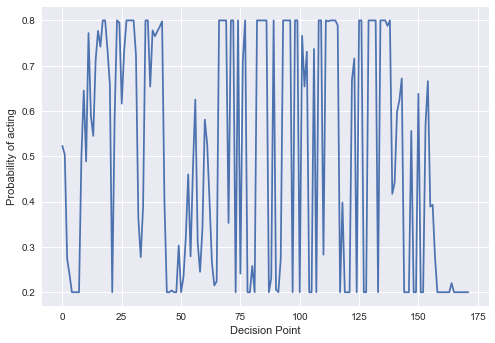

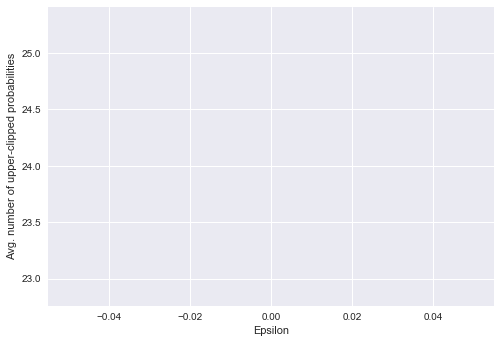

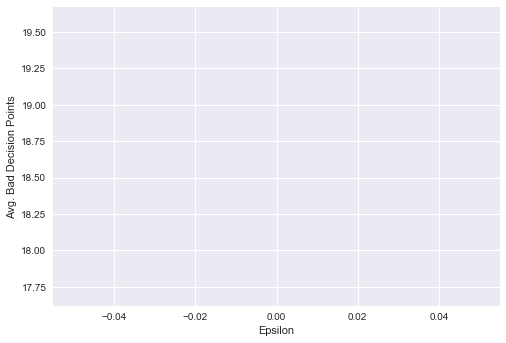

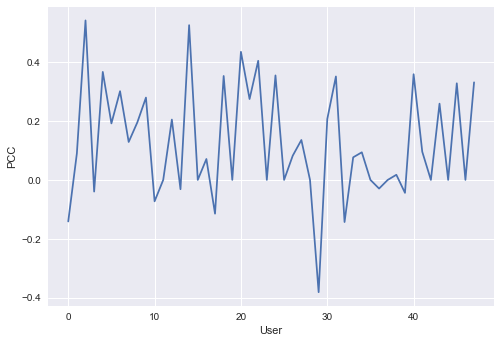

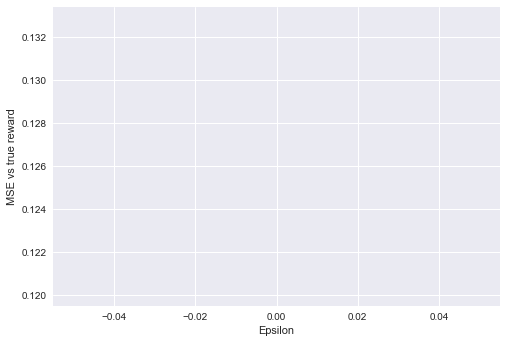

In [29]:
#Get the features from the HeartSteps data and run the bandit
import pickle
num_interact = 4
ddf,pd_df = read_hs1(1)
epz = np.array([0]) #,.001,.005,.01,.02,.05])
epz = epz*6
bad_dec = np.zeros((max(pd_df.user.unique()), len(epz)))
rwd_cor = np.zeros((max(pd_df.user.unique()), len(epz)))
clips = np.zeros((max(pd_df.user.unique()),len(epz)))
fin_thets = np.zeros((max(pd_df.user.unique()),num_interact + n))

sents_day = np.zeros((1+max(pd_df.user.unique()), 42))

for k in range(len(epz)):
    for yoozer in pd_df.user.unique():
    
    
        epsilon = epz[k]

        #Load in HS1 data


        ddf,pd_df = read_hs1(yoozer)

        #Make features
        #Center and scale

        decision_ind = ddf['decision.index.nogap']
        state = (ddf['jbsteps30pre.log'] - np.mean(pd_df['jbsteps30pre.log']))/np.std(pd_df['jbsteps30pre.log'])
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']
        #total_sent = ddf['totalSent']

        #Other states to make
        #sq root of steps in prior day
        #sqrtStp = 
        # SD of num steps in 60-min window from prev 7 days
        #stdDevStp = 
        # Study day index
        dazze = ddf['study.day.nogap']
        
        
        day_ind  = (ddf['study.day.nogap'] - np.mean(pd_df['study.day.nogap']))/np.std(pd_df['study.day.nogap'])#Number sent in last whatever
        #Add feature for # of week period (hsteps v2) WATCH OUT FOR COLINEARITY WITH INTERCEPT
        # Temperature (deg C)
        #tempC = #dnot in dataframe
        # Work indicator
        #wrk_ind = ddf['location.category']
        wrk_ind = ddf['loc.is.work'] #compare to string "work"
        # Location indicator
        loc_ind = ddf['loc.is.other'] #compare to string "work"
        #loc_ind = ddf['location.category']
        steps_yest = (ddf['steps.yesterday.sqrt'] - np.mean(pd_df['steps.yesterday.sqrt']))/np.std(pd_df['steps.yesterday.sqrt'])
        #steps_avg = ddf['daily.sqrt.steps.exp4']
        steps_sd = (ddf['window7.steps60.sd'] - np.mean(pd_df['window7.steps60.sd']))/np.std(pd_df['window7.steps60.sd'])
        temp = (ddf['temperature'] - np.mean(pd_df['temperature']))/np.std(pd_df['temperature'])
        temp[ddf['temperature'] == -1024] = 0
        
        ddfgf,pd_dfgf = read_hs1_gf(yoozer)
        
        steps_gf = (np.log(ddfgf['gfsteps30pre'] + .5) - np.mean(np.log(pd_dfgf['gfsteps30pre'] + .5))/np.std(np.log(pd_dfgf['gfsteps30pre']+.5)))
        

    
        T = len(send_active)


        #Create a bandit object
        #[minprob, maxprob, priorweight]
        params = [.2, .8, 1]
        #params.pi_max = .15
        #prioR = np.diag(np.array([.515, .201, .833, .388, .722, .107, .370, .318, .161, 1.07, .123, 1.04]))
        prioR = np.diag(np.ones(13))
        prior_mdl= model(np.zeros((n + num_interact,1)),prioR, sig,epsilon)
        bandit = ContextBandit(params,prior_mdl,num_interact)
        filename = 'contextBandit.obj'
        filehandle = open(filename,'w')
        pickle.dump(bandit,filehandle)

        regret = np.zeros(T*t)
        probs= np.zeros(T*t)
        action = np.zeros(T*t)
        action_opt = np.zeros(T*t)
        rewrd = np.zeros(T*t)
        moofs = np.zeros(T*t)
        rwds = np.zeros(T*t)
        pred_rwd = np.zeros(T*t)
        #Cycle thru days
        for day in range(T):
            #Cycle thru decision points
            rwd = np.zeros(t)
        
            featVec = np.zeros((n,t))
    
            for dpt in range(t):
                #Generate random state vector 
                
                sents_day[yoozer,dazze[day]] += 1*send_any[day]
                
                if flag_hstp == 1:
                    #print(state[day])
                    vc = state[day]
                    featVec[:,dpt] = np.ones(n)
                    featVec[4,dpt] = vc
                    #featVec[2,dpt] = sqrtStp[day]
                    #featVec[3,dpt] = stdDevStp[day]
                    featVec[1,dpt] = day_ind[day]
                    #featVec[5,dpt] = tempC[day]
                    featVec[5,dpt] = int(wrk_ind[day])
                    featVec[2,dpt] = int(loc_ind[day])
                    featVec[6,dpt] = steps_yest[day]
                    #featVec[6,dpt] = steps_avg[day]
                    featVec[3,dpt] = float(steps_sd[day])
                    featVec[7,dpt] = float(temp[day])
                    featVec[8,dpt] = float(steps_gf[day])
                
                    featVec[np.isnan(featVec)] = 0


                else:
                    featVec[:,dpt] = np.abs(np.random.normal(0,1,n) + .5*np.ones(n))
        
                #Unpickle bandit
                filehandle = open(filename, 'r') 
                bandit = pickle.load(filehandle)
        
                #Regress previous rewards
                bck = min(day, 10)
                num1 = np.sum(action[day*t - bck:day*t-1]) #action version
                num1 = np.sum(probs[day*t - bck:day*t-1]) #prob version
                #rwdRec = rwd
        
                alph= 6#2*0.001 #Feedback coefficient
                #print(rwd0 + alph*(num1/(1 + bck) - .5), rwd1 + alph*(.5-num1/(1+bck))) 
        
                #Get action probability
                if 0: #Do nothing
                    probs[day*t + dpt] = 0
        #if 0: #Use prediction of future state
        #    modl = bandit.get_reward_func()
        #    avg_state = .5*np.ones(n)
        #    base_rwd = np.dot(avg_state, modl.theta)
        #    #Log decay per action in recent past 
        #    decay = np.exp(-.35)
        #    #Number of actions in last day
        #    tdy = sum(action[max(0,day*t + dpt - 5):day*t+dpt])
        #    #Lost future reward if take action 1
        #    def_rwd = (1-decay)*5*1*base_rwd
        #    probs[day*t + dpt] = action_probability(featVec[:,dpt],bandit, -def_rwd)
                else: #Use feedback control
                    mu_off = alph*(.6-num1/(bck+.00001)) #Feedback offset
                    mu_off = min(mu_off, 0) # Optional - puts .6 as the ceiling action rate
                    moofs[day*t + dpt] = mu_off
                    probs[day*t + dpt] = action_probability(featVec[0:num_interact,dpt],bandit, mu_off)
            
        
                #Choose action randomly
                if flag_hstp == 1:
                    action[day*t + dpt] = send_active[day]
                    fV = featVec[:,dpt]
                    fVV = featVec[0:num_interact,dpt]
                    fTilde = np.concatenate(((action[day*t+dpt] - probs[day*t+dpt])*fVV.reshape((-1,1)), fV.reshape((-1,1))), axis = 0)
                    pred_rwd[day*t + dpt] = np.dot(fTilde.transpose(),bandit.model.mean)
                else:
                    if np.random.rand() < probs[day*t + dpt]:
                        action[day*t + dpt] = 1
                    else:
                        action[day*t + dpt] = 0
                
        
        
                #Receive reward
                if flag_hstp == 1:
                    rwd[dpt] = reward_h[day]
                    rwds[day*t+dpt] = rwd[dpt]
                else:
                    rwd[dpt] = reward(featVec[:,dpt],action[day*t + dpt],coef0,coef1,sig) #/np.sqrt(1 + num1)fff
            
                rewrd[day*t + dpt] = rwd[dpt]
        
                #What was expected regret?
                #rwdExp = reward(featVec[:,dpt],action[day*t + dpt],coef0,coef1,0)
                rwd0 = reward(featVec[:,dpt],0,coef0,coef1,0)
                rwd1 = reward(featVec[:,dpt],1,coef0,coef1,0)
            
                rwdExp = probs[day*t + dpt]*rwd1 + (1-probs[day*t + dpt])*rwd0
                #pred_rwd = abs(np.dot(featVec[:,dpt] , bandit.model.theta))
        
                #Regret is difference between optimal reward and the reward we got
                regret[day*t + dpt] = max(params[0]*rwd0 + params[1]*rwd1,params[0]*rwd1 + params[1]*rwd0) - rwdExp
                #alph*(num1/(1 + bck) - .5))
                #print(rwd1 + alph*(.5-num1/(1+bck)))
                if rwd0 > rwd1 + mu_off:
                    action_opt[day*t + dpt] = 0
                else:
                    action_opt[day*t+dpt] = 1
            
                #print rwdExp, rwd0, rwd1, pred_rwd
        
            #Perform bandit updates
            #Unpickle bandit
            filehandle = open(filename, 'r') 
            bandit = pickle.load(filehandle)
    
            for dpt in range(t):
        
        
        
                bandit.update_model(featVec[:,dpt],featVec[0:num_interact,:],rwd[dpt],np.zeros(n),action[day*t + dpt],probs[day*t + dpt])
        
            #Pickle it back up
            filehandle = open(filename,'w')
            pickle.dump(bandit,filehandle)
        
        fin_thets[yoozer-1,:] = bandit.model.mean.transpose()
        bad_dec[yoozer-1,k] = sum(moofs != 0)
        pred_rwd[np.abs(pred_rwd) > 10] = 0
        clips[yoozer-1,k] = sum(probs == .8)
        rwd_cor[yoozer-1,k] = np.dot(rwds -pred_rwd, rwd-pred_rwd)/(np.std(rwds)*np.std(rwds)*len(rwds))
        #rwd_cor[yoozer-1,k] = np.dot(rwds - np.mean(rwds),pred_rwd-np.mean(pred_rwd))/(np.std(rwds)*np.std(pred_rwd)*len(rwds))
        
        #Plot cumulative regret
        #plt.plot(np.cumsum(regret))
    
        #plt.plot(rewrd)

fig = plt.figure()
plt.plot(probs) #probabilities of taking action 1
plt.xlabel('Decision Point')
plt.ylabel('Probability of acting')
print 'Mean probability of acting =',np.mean(action)
fig = plt.figure()
plt.plot(epz,np.mean(clips,axis=0))
plt.xlabel('Epsilon')
plt.ylabel('Avg. number of upper-clipped probabilities')
fig = plt.figure()
plt.plot(epz,np.mean(bad_dec,axis=0))
plt.xlabel('Epsilon')
plt.ylabel('Avg. Bad Decision Points')
fig = plt.figure()
plt.plot(np.mean(rwd_cor,axis=1))
plt.xlabel('User')
plt.ylabel('PCC')
fig = plt.figure()
plt.plot(epz,np.mean(rwd_cor,axis=0))
plt.xlabel('Epsilon')
plt.ylabel('MSE vs true reward')
mn_thets = 0*fin_thets[0,:]
var_thets = 0*fin_thets[0,:]
for yoozer in pd_df.user.unique():
    mn_thets = mn_thets + fin_thets[yoozer - 1, :]
mn_thets = mn_thets/len(pd_df.user.unique())
for yoozer in pd_df.user.unique():
    var_thets = var_thets + (fin_thets[yoozer - 1, :] - mn_thets)**2
    
var_thets = var_thets/len(pd_df.user.unique())

#HOW OFTEN CLIPPING. 

0.56690059063220477

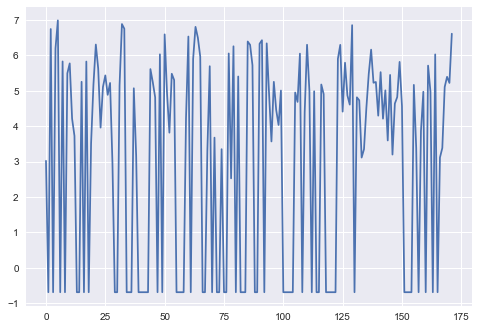

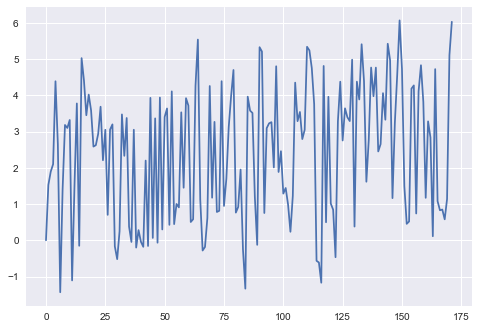

In [17]:
fig = plt.figure()
plt.plot(rwds)
fig = plt.figure()
pred = pred_rwd
pred[np.abs(pred) > 10] = 0
plt.plot(pred_rwd)
np.dot(rwds - np.mean(rwds),pred_rwd-np.mean(pred_rwd))/(np.std(rwds)*np.std(pred_rwd)*len(rwds))

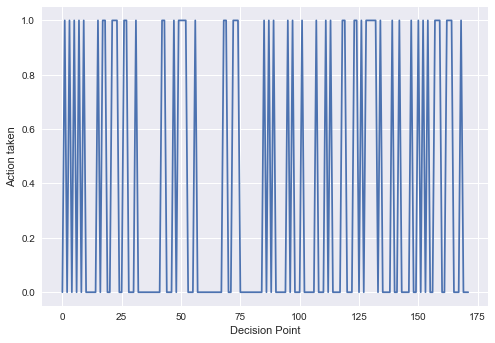

In [18]:
plt.plot(action) #actions taken
plt.xlabel('Decision Point')
plt.ylabel('Action taken')

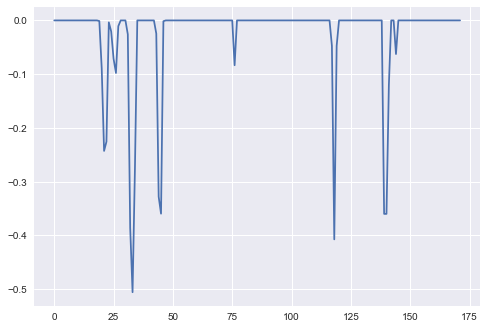

In [19]:
plt.plot(moofs)


In [ ]:
state[5]

In [ ]:
int(5 == 5)

In [17]:
float('NA')

ValueError: could not convert string to float: NA

temp[1]

In [19]:
temp[1]

20.899999999999999

In [20]:
steps_sd[1]

nan

In [17]:
sum(moofs != 0)

25

In [16]:
np.mean(bad_dec,axis=0)

array([ 20.66666667,  13.4375    ,   5.0625    ,   1.70833333,
         0.25      ,   0.        ])

In [26]:
bandit.model.mean

array([[  1.43711035e-01],
       [ -3.03858588e-01],
       [  0.00000000e+00],
       [ -1.67304127e-01],
       [ -3.77509164e-01],
       [ -2.59350809e-02],
       [  3.25950940e-03],
       [  1.30481695e-03],
       [  1.87106417e-01],
       [  7.30012045e-01],
       [  4.49871354e-01],
       [  0.00000000e+00],
       [ -9.51142165e-01],
       [  1.75223369e-01],
       [ -2.34939274e-03],
       [  7.40324876e-03],
       [  6.12063315e-05],
       [  9.30609965e-02]])

In [22]:
mn_thets

array([ 0.2342239 , -0.17922257, -0.22764023,  0.06258452,  2.36600746,
       -0.05419958,  0.73172119,  0.24154131,  1.17657561,  0.36079689,
        0.10873605,  0.33528089,  0.00914143])

In [21]:
var_thets

array([ 0.40291271,  0.17325303,  0.53671829,  0.34731918,  0.47905314,
        0.12496002,  0.27316088,  0.21718316,  0.18228279,  0.81024968,
        0.10392959,  0.74627249,  0.01307472])

In [51]:
n + num_interact

13

In [52]:
n

9

In [96]:
bandit.model.cov


array([[  2.84331708e-01,  -6.22519279e-02,  -9.21962786e-02,
          9.51718227e-02,   1.25416290e-02,  -8.99311202e-03,
         -1.87405136e-02,   7.68298083e-04,  -4.23226964e-03,
          2.21479379e-03,   8.08099448e-04,  -7.40527277e-04],
       [ -6.22519279e-02,   1.45978717e-01,   3.34944949e-03,
          4.56577337e-02,  -1.42690329e-02,  -8.15175753e-04,
          6.98858411e-03,   4.24791283e-04,  -2.16798191e-03,
          1.46454340e-02,  -4.95837502e-04,  -9.00825343e-04],
       [ -9.21962786e-02,   3.34944949e-03,   5.12495307e-01,
          1.61606000e-02,  -1.58844468e-02,   4.42273400e-03,
          1.96777199e-02,  -6.20992365e-03,   1.24861067e-02,
          5.13849986e-03,   3.30651906e-03,   4.14745987e-03],
       [  9.51718227e-02,   4.56577337e-02,   1.61606000e-02,
          4.27234275e-01,  -1.05537228e-03,   2.46213689e-03,
          5.62956136e-03,   3.43662302e-02,   1.05332892e-02,
          1.38448709e-02,  -1.43556142e-03,   4.08291436e-03],
    

In [113]:
print(np.mean(pd_df['steps.yesterday.sqrt']))
print(np.std(pd_df['steps.yesterday.sqrt']))
        #steps_avg = ddf['daily.sqrt.steps.exp4']
print(np.mean(pd_df['window7.steps60.sd']))
print(np.std(pd_df['window7.steps60.sd']))
tmps = pd_df['temperature']
tmps[tmps == -1024] = float('nan')
print(np.mean(tmps))
print(np.std(tmps))
print(np.mean(pd_df['jbsteps30pre.log']))
print(np.std(pd_df['jbsteps30pre.log']))

83.1317933316
32.5136091249
523.323026451
494.525677792
12.9916605706
10.4120618581
2.88390440904
3.06767399885


/Users/Kristjan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
steps_gf

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
159   NaN
160   NaN
161   NaN
162   NaN
163   NaN
164   NaN
165   NaN
166   NaN
167   NaN
168   NaN
169   NaN
170   NaN
171   NaN
172   NaN
173   NaN
174   NaN
175   NaN
176   NaN
177   NaN
178   NaN
179   NaN
180   NaN
181   NaN
182   NaN
183   NaN
184   NaN
185   NaN
186   NaN
187   NaN
188   NaN
Name: gfsteps30pre, dtype: float64

In [16]:
ddfgf['gfsteps30pre']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
159   NaN
160   NaN
161   NaN
162   NaN
163   NaN
164   NaN
165   NaN
166   NaN
167   NaN
168   NaN
169   NaN
170   NaN
171   NaN
172   NaN
173   NaN
174   NaN
175   NaN
176   NaN
177   NaN
178   NaN
179   NaN
180   NaN
181   NaN
182   NaN
183   NaN
184   NaN
185   NaN
186   NaN
187   NaN
188   NaN
Name: gfsteps30pre, dtype: float64

In [7]:
sents_day


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [21]:
np.max(np.max(sents_day))

5.0

In [12]:
(4 > 3)

True

In [22]:
sents_day

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  2.,  0.,  1.],
       ..., 
       [ 2.,  1.,  2., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  3.,  2., ...,  3.,  1.,  0.]])

In [73]:
valz = np.zeros(((1+max(pd_df.user.unique())),42))
for i in range(1+max(pd_df.user.unique())):
    for j in range(42):#5):
        valz[i,j] = np.sum(sents_day[i,1*j+1:1*j+7])
               

In [66]:
valz

array([[  0.,   0.,   0.,   0.,   0.],
       [ 11.,  13.,  10.,   8.,   4.],
       [  6.,   6.,   9.,  11.,   8.],
       [  9.,  12.,   7.,  11.,   6.],
       [  7.,   8.,   8.,   9.,  11.],
       [  6.,   8.,   8.,   6.,   7.],
       [  4.,  12.,   5.,   6.,   5.],
       [ 11.,   7.,  12.,   8.,   9.],
       [ 10.,   8.,   8.,  12.,  11.],
       [  6.,  11.,  11.,   4.,   4.],
       [  9.,   7.,   6.,   4.,   6.],
       [  6.,  11.,   8.,   9.,   3.],
       [  0.,   0.,   0.,   0.,   0.],
       [  9.,   7.,   5.,   5.,   9.],
       [ 11.,   7.,   5.,   8.,   6.],
       [  3.,   5.,   9.,  10.,   9.],
       [  0.,   0.,   0.,   0.,   0.],
       [  5.,   4.,   4.,   2.,   6.],
       [  7.,   9.,  10.,  10.,   9.],
       [  9.,   9.,   5.,   8.,  11.],
       [  0.,   0.,   0.,   0.,   0.],
       [  7.,   9.,   9.,   6.,   9.],
       [  6.,   7.,  10.,   9.,   7.],
       [  5.,   7.,   9.,   8.,  12.],
       [  0.,   0.,   0.,   0.,   0.],
       [ 12.,   9.,  14.,

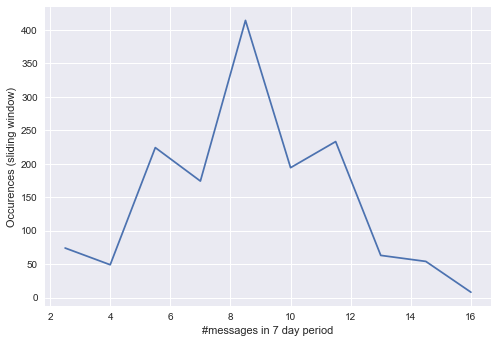

In [77]:
hist, bin_edges = np.histogram(valz[valz>0])
plt.plot(bin_edges[1:],hist)
plt.xlabel('#messages in 7 day period')
plt.ylabel('Occurences (sliding window)')

In [75]:
np.mean(valz[valz > 0])

7.542703429724277

In [76]:
np.std(valz[valz > 0])

2.8477433971645851

In [45]:
len(pd_df.user.unique())

37